In [70]:
words = open('names.txt', 'r').read().splitlines()

In [71]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [72]:
len(words)

32033

In [73]:
min([len(w) for w in words])

2

In [74]:
max([len(w) for w in words])

15

In [75]:
b = {}
for w in words:
    chs = ['<s>'] + list(w) + ['<e>']
    for ch1, ch2 in zip(chs[:-1], chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [76]:
sorted(b.items(), key = lambda kv : kv[1], reverse = True)[:5]

[(('n', '<e>'), 6763),
 (('a', '<e>'), 6640),
 (('a', 'n'), 5438),
 (('<s>', 'a'), 4410),
 (('e', '<e>'), 3983)]

In [77]:
import torch

In [78]:
N  = torch.zeros((27, 27), dtype = torch.int64)

In [79]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

In [80]:
itos = {i:s for s, i in stoi.items()}

In [81]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

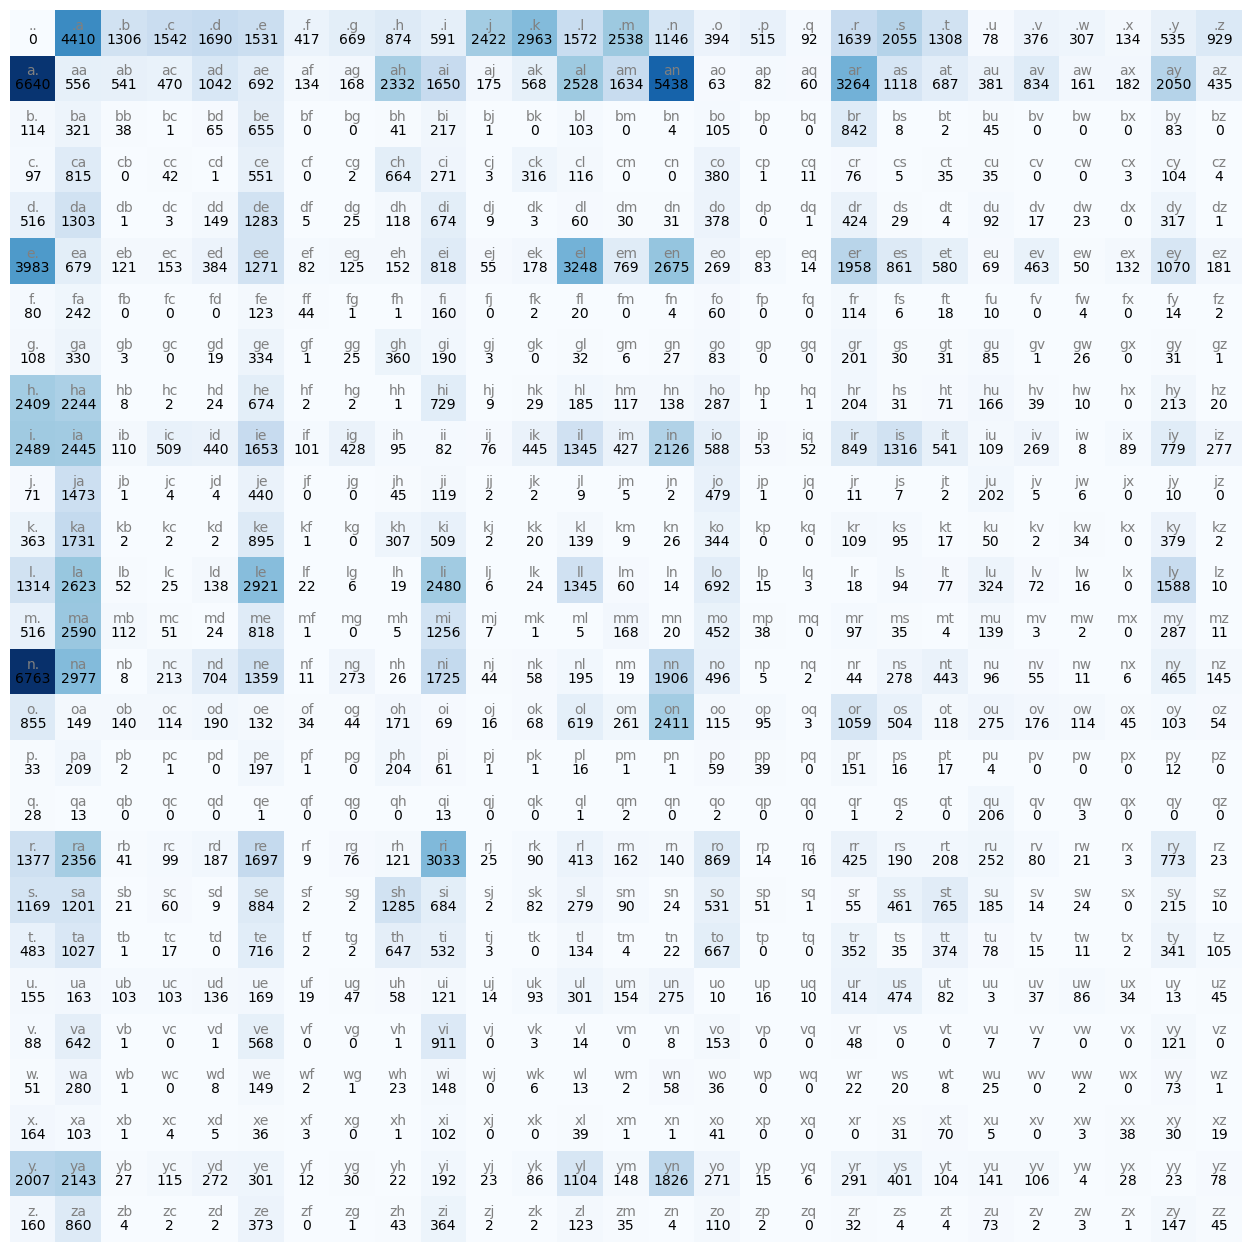

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (16, 16))
plt.imshow(N, cmap = 'Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center',va = 'bottom', color='grey')
        plt.text(j, i, N[i, j].item(), ha='center',va = 'top', color='black')
plt.axis('off')

In [83]:
N[0,:]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929])

In [84]:
p = N[0].float()

In [85]:
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [86]:
sum(p)

tensor(1.)

In [87]:
g = torch.Generator().manual_seed(42)
p = torch.rand(3, generator = g)

In [88]:
p = p / p.sum()
p

tensor([0.4047, 0.4197, 0.1756])

In [89]:
torch.multinomial(p, num_samples=20, replacement = True, generator=g)

tensor([1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2])

In [90]:
p = N[0].float()
p = p / p.sum()
g = torch.Generator().manual_seed(43)
ix = torch.multinomial(p, num_samples=1, replacement = True, generator=g).item()
itos[ix]

'h'

In [91]:
P = (N + 1).float()
P = P / P.sum(1, keepdim=True)


In [92]:
ix = 0
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

bronixiy.
kenisinomannana.
minnorietylich.
ar.
ey.


In [93]:
log_likelihood = 0.0
n = 0
for w in ["jq"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

.j: 0.0756 -2.5826
jq: 0.0003 -7.9817
q.: 0.0970 -2.3331
log_likelihood=tensor(-12.8975)
nll=tensor(12.8975)
4.299161434173584


In [96]:
import torch.nn.functional as F

In [174]:
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

g = torch.Generator().manual_seed(42)
w = torch.randn((27, 27), generator=g, requires_grad=True)

In [176]:
for k in range(1000):
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ w
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.001*(w**2).mean()
    print(loss.item())

    w.grad = None
    loss.backward()

    w.data += -10 * w.grad

2.568033218383789
2.566904306411743
2.5657958984375
2.5647077560424805
2.5636396408081055
2.5625901222229004
2.5615594387054443
2.560547351837158
2.5595526695251465
2.55857515335083
2.5576138496398926
2.5566701889038086
2.555741786956787
2.554828643798828
2.5539309978485107
2.553048849105835
2.552180290222168
2.551326274871826
2.550485849380493
2.549659252166748
2.5488457679748535
2.5480446815490723
2.5472567081451416
2.546480894088745
2.5457170009613037
2.544964551925659
2.5442240238189697
2.543494701385498
2.542776107788086
2.5420682430267334
2.5413708686828613
2.5406839847564697
2.5400068759918213
2.539339780807495
2.538681983947754
2.5380337238311768
2.5373947620391846
2.5367650985717773
2.5361440181732178
2.535531520843506
2.5349276065826416
2.534332275390625
2.5337443351745605
2.5331647396087646
2.532593250274658
2.532028913497925
2.531472682952881
2.530923366546631
2.530381441116333
2.529846429824829
2.5293185710906982
2.528797149658203
2.528282642364502
2.5277745723724365
2.527

In [189]:
ix = 0
for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
       # print(xenc)
        logits = xenc @ w
        counts = logits.exp()
        p = counts / counts.sum(1, keepdim=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

phaya.
n.
re.
myononavondikisode.
thaidaan.
